## Imports

In [2]:
# Native libraries
import time
import copy
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter("ignore")

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 42

https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering

## 1. ETL (Extract, Transform, Load)

In [4]:
df = pd.read_csv('datasets/all_2000_user_means.csv')
df

MeterID  user         0         1         2         3         4   
0     6200093839     0  0.793782  0.806860  0.800848  0.788947  0.789313  \
1     6200093048     1  0.041691  0.042938  0.042560  0.041551  0.040790   
2     6200085183     2  0.114519  0.118584  0.116782  0.111737  0.112181   
3     6200059982     3  0.170506  0.165831  0.153872  0.142395  0.133942   
4     6200063890     4  0.097938  0.094436  0.096247  0.095243  0.092761   
...          ...   ...       ...       ...       ...       ...       ...   
1996  6200050860  1996  0.388585  0.399708  0.394156  0.391014  0.385222   
1997  6200050862  1997  0.411028  0.411231  0.400396  0.385151  0.369099   
1998  6200050858  1998  0.019802  0.020330  0.019755  0.020316  0.021354   
1999  6200051042  1999  0.071825  0.070642  0.068693  0.068222  0.066439   
2000  6200051044  2000  0.285179  0.290142  0.279132  0.270571  0.264670   

             5         6         7  ...        86        87        88   
0     0.767975  0.769679  0.751206  ...  0.722720  0.734066  0.751667  \
1     0.040354  0.040226  0.039733  ...  0.059342  0.057185  0.055041   
2     0.107630  0.108683  0.102934  ...  0.151885  0.144255  0.135827   
3     0.130494  0.126901  0.127193  ...  0.287523  0.279782  0.272053   
4     0.095033  0.092370  0.091309  ...  0.101358  0.100169  0.100313   
...        ...       ...       ...  ...       ...       ...       ...   
1996  0.376538  0.372198  0.371741  ...  0.538863  0.505590  0.465703   
1997  0.356368  0.339241  0.323774  ...  0.577495  0.568868  0.558321   
1998  0.021226  0.020292  0.018448  ...  0.015090  0.016047  0.016585   
1999  0.062396  0.062038  0.062245  ...  0.173613  0.149509  0.132335   
2000  0.259278  0.256028  0.255396  ...  0.405514  0.390906  0.373127   

            89        90        91        92        93        94        95  
0     0.778778  0.795844  0.789346  0.794778  0.796082  0.792325  0.796008  
1     0.052202  0.048926  0.047021  0.045280  0.043815  0.043263  0.042198  
2     0.131691  0.126115  0.126082  0.124058  0.121074  0.119366  0.117086  
3     0.254453  0.237963  0.229202  0.223638  0.216510  0.204082  0.184267  
4     0.099770  0.096185  0.098502  0.098309  0.099757  0.097309  0.099914  
...        ...       ...       ...       ...       ...       ...       ...  
1996  0.451953  0.434585  0.422505  0.413858  0.403651  0.400792  0.395939  
1997  0.547684  0.528708  0.505189  0.478264  0.451571  0.438967  0.429226  
1998  0.017274  0.018769  0.019693  0.019604  0.019368  0.018774  0.019335  
1999  0.117524  0.105542  0.095198  0.088802  0.081585  0.074769  0.074816  
2000  0.357840  0.340274  0.332198  0.320151  0.311684  0.299108  0.295259  

[2001 rows x 98 columns]

In [5]:
df = df.drop(columns=['MeterID'])
df = df.set_index('user')
df

0         1         2         3         4         5         6   
user                                                                         
0     0.793782  0.806860  0.800848  0.788947  0.789313  0.767975  0.769679  \
1     0.041691  0.042938  0.042560  0.041551  0.040790  0.040354  0.040226   
2     0.114519  0.118584  0.116782  0.111737  0.112181  0.107630  0.108683   
3     0.170506  0.165831  0.153872  0.142395  0.133942  0.130494  0.126901   
4     0.097938  0.094436  0.096247  0.095243  0.092761  0.095033  0.092370   
...        ...       ...       ...       ...       ...       ...       ...   
1996  0.388585  0.399708  0.394156  0.391014  0.385222  0.376538  0.372198   
1997  0.411028  0.411231  0.400396  0.385151  0.369099  0.356368  0.339241   
1998  0.019802  0.020330  0.019755  0.020316  0.021354  0.021226  0.020292   
1999  0.071825  0.070642  0.068693  0.068222  0.066439  0.062396  0.062038   
2000  0.285179  0.290142  0.279132  0.270571  0.264670  0.259278  0.256028   

             7         8         9  ...        86        87        88   
user                                ...                                 
0     0.751206  0.746905  0.736597  ...  0.722720  0.734066  0.751667  \
1     0.039733  0.039099  0.039115  ...  0.059342  0.057185  0.055041   
2     0.102934  0.102909  0.106366  ...  0.151885  0.144255  0.135827   
3     0.127193  0.128588  0.133576  ...  0.287523  0.279782  0.272053   
4     0.091309  0.092840  0.096049  ...  0.101358  0.100169  0.100313   
...        ...       ...       ...  ...       ...       ...       ...   
1996  0.371741  0.372014  0.365712  ...  0.538863  0.505590  0.465703   
1997  0.323774  0.306066  0.300967  ...  0.577495  0.568868  0.558321   
1998  0.018448  0.018481  0.019406  ...  0.015090  0.016047  0.016585   
1999  0.062245  0.061547  0.061745  ...  0.173613  0.149509  0.132335   
2000  0.255396  0.246575  0.244321  ...  0.405514  0.390906  0.373127   

            89        90        91        92        93        94        95  
user                                                                        
0     0.778778  0.795844  0.789346  0.794778  0.796082  0.792325  0.796008  
1     0.052202  0.048926  0.047021  0.045280  0.043815  0.043263  0.042198  
2     0.131691  0.126115  0.126082  0.124058  0.121074  0.119366  0.117086  
3     0.254453  0.237963  0.229202  0.223638  0.216510  0.204082  0.184267  
4     0.099770  0.096185  0.098502  0.098309  0.099757  0.097309  0.099914  
...        ...       ...       ...       ...       ...       ...       ...  
1996  0.451953  0.434585  0.422505  0.413858  0.403651  0.400792  0.395939  
1997  0.547684  0.528708  0.505189  0.478264  0.451571  0.438967  0.429226  
1998  0.017274  0.018769  0.019693  0.019604  0.019368  0.018774  0.019335  
1999  0.117524  0.105542  0.095198  0.088802  0.081585  0.074769  0.074816  
2000  0.357840  0.340274  0.332198  0.320151  0.311684  0.299108  0.295259  

[2001 rows x 96 columns]

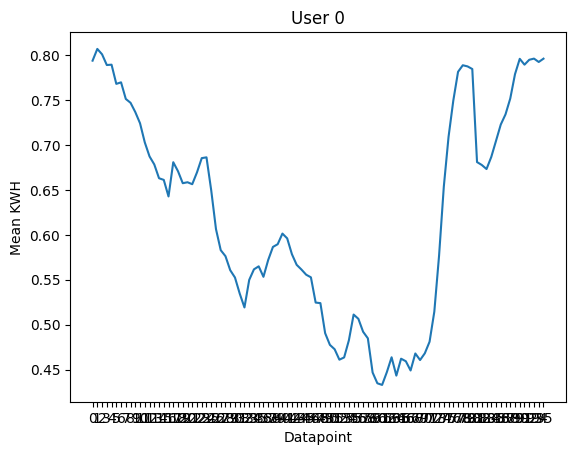

In [6]:
# Select row for user 0
user0_data = df.loc[0]

plt.plot(user0_data.index, user0_data.values)
plt.xlabel('Datapoint')
plt.ylabel('Mean KWH')
plt.title('User 0')
plt.show()

In [7]:
df_test = df.copy()
df_test

0         1         2         3         4         5         6   
user                                                                         
0     0.793782  0.806860  0.800848  0.788947  0.789313  0.767975  0.769679  \
1     0.041691  0.042938  0.042560  0.041551  0.040790  0.040354  0.040226   
2     0.114519  0.118584  0.116782  0.111737  0.112181  0.107630  0.108683   
3     0.170506  0.165831  0.153872  0.142395  0.133942  0.130494  0.126901   
4     0.097938  0.094436  0.096247  0.095243  0.092761  0.095033  0.092370   
...        ...       ...       ...       ...       ...       ...       ...   
1996  0.388585  0.399708  0.394156  0.391014  0.385222  0.376538  0.372198   
1997  0.411028  0.411231  0.400396  0.385151  0.369099  0.356368  0.339241   
1998  0.019802  0.020330  0.019755  0.020316  0.021354  0.021226  0.020292   
1999  0.071825  0.070642  0.068693  0.068222  0.066439  0.062396  0.062038   
2000  0.285179  0.290142  0.279132  0.270571  0.264670  0.259278  0.256028   

             7         8         9  ...        86        87        88   
user                                ...                                 
0     0.751206  0.746905  0.736597  ...  0.722720  0.734066  0.751667  \
1     0.039733  0.039099  0.039115  ...  0.059342  0.057185  0.055041   
2     0.102934  0.102909  0.106366  ...  0.151885  0.144255  0.135827   
3     0.127193  0.128588  0.133576  ...  0.287523  0.279782  0.272053   
4     0.091309  0.092840  0.096049  ...  0.101358  0.100169  0.100313   
...        ...       ...       ...  ...       ...       ...       ...   
1996  0.371741  0.372014  0.365712  ...  0.538863  0.505590  0.465703   
1997  0.323774  0.306066  0.300967  ...  0.577495  0.568868  0.558321   
1998  0.018448  0.018481  0.019406  ...  0.015090  0.016047  0.016585   
1999  0.062245  0.061547  0.061745  ...  0.173613  0.149509  0.132335   
2000  0.255396  0.246575  0.244321  ...  0.405514  0.390906  0.373127   

            89        90        91        92        93        94        95  
user                                                                        
0     0.778778  0.795844  0.789346  0.794778  0.796082  0.792325  0.796008  
1     0.052202  0.048926  0.047021  0.045280  0.043815  0.043263  0.042198  
2     0.131691  0.126115  0.126082  0.124058  0.121074  0.119366  0.117086  
3     0.254453  0.237963  0.229202  0.223638  0.216510  0.204082  0.184267  
4     0.099770  0.096185  0.098502  0.098309  0.099757  0.097309  0.099914  
...        ...       ...       ...       ...       ...       ...       ...  
1996  0.451953  0.434585  0.422505  0.413858  0.403651  0.400792  0.395939  
1997  0.547684  0.528708  0.505189  0.478264  0.451571  0.438967  0.429226  
1998  0.017274  0.018769  0.019693  0.019604  0.019368  0.018774  0.019335  
1999  0.117524  0.105542  0.095198  0.088802  0.081585  0.074769  0.074816  
2000  0.357840  0.340274  0.332198  0.320151  0.311684  0.299108  0.295259  

[2001 rows x 96 columns]

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Loop over the rows of the pivoted dataframe
for index, row in df_test.iterrows():
    
    # Extract the time series data from the row
    data = row.values.reshape(-1, 1)
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)
    
    # Replace the original data with the normalized data
    df_test.loc[index] = data_normalized.flatten()

In [9]:
df_test

0         1         2         3         4         5         6   
user                                                                         
0     0.965017  1.000000  0.983917  0.952082  0.953062  0.895985  0.900543  \
1     0.053752  0.075910  0.069182  0.051265  0.037736  0.029984  0.027717   
2     0.183432  0.206546  0.196299  0.167618  0.170145  0.144271  0.150260   
3     0.158932  0.142264  0.099626  0.058704  0.028567  0.016272  0.003463   
4     0.006244  0.003043  0.004698  0.003780  0.001512  0.003589  0.001155   
...        ...       ...       ...       ...       ...       ...       ...   
1996  0.125294  0.160004  0.142678  0.132875  0.114799  0.087700  0.074158   
1997  0.402743  0.403273  0.374971  0.335149  0.293220  0.259965  0.215227   
1998  0.844738  0.897593  0.840019  0.896177  1.000000  0.987258  0.893818   
1999  0.083057  0.073691  0.058281  0.054550  0.040446  0.008470  0.005634   
2000  0.379475  0.395261  0.360238  0.333003  0.314231  0.297080  0.286741   

             7         8         9  ...        86        87        88   
user                                ...                                 
0     0.851128  0.839624  0.812049  ...  0.774930  0.805279  0.852361  \
1     0.018941  0.007679  0.007971  ...  0.367413  0.329092  0.290990   
2     0.117578  0.117438  0.137089  ...  0.395850  0.352477  0.304567   
3     0.004504  0.009478  0.027261  ...  0.576143  0.548544  0.520989   
4     0.000184  0.001584  0.004518  ...  0.009370  0.008283  0.008415   
...        ...       ...       ...  ...       ...       ...       ...   
1996  0.072730  0.073584  0.053918  ...  0.594250  0.490417  0.365947   
1997  0.174825  0.128572  0.115252  ...  0.837570  0.815034  0.787484   
1998  0.709297  0.712600  0.805097  ...  0.373289  0.469089  0.522888   
1999  0.007276  0.001754  0.003321  ...  0.888213  0.697549  0.561695   
2000  0.284730  0.256670  0.249497  ...  0.762282  0.715810  0.659254   

            89        90        91        92        93        94        95  
user                                                                        
0     0.924881  0.970532  0.953150  0.967681  0.971170  0.961120  0.970972  
1     0.240529  0.182317  0.148457  0.117522  0.091487  0.081688  0.062747  
2     0.281056  0.249357  0.249170  0.237660  0.220699  0.210991  0.198030  
3     0.458235  0.399442  0.368205  0.348368  0.322955  0.278644  0.207996  
4     0.007918  0.004642  0.006760  0.006583  0.007907  0.005669  0.008050  
...        ...       ...       ...       ...       ...       ...       ...  
1996  0.323039  0.268841  0.231144  0.204163  0.172309  0.163389  0.148242  
1997  0.759700  0.710132  0.648698  0.578369  0.508643  0.475721  0.450278  
1998  0.591789  0.741387  0.833884  0.824917  0.801321  0.741859  0.798018  
1999  0.444536  0.349763  0.267938  0.217343  0.160255  0.106339  0.106712  
2000  0.610621  0.554740  0.529051  0.490727  0.463792  0.423787  0.411542  

[2001 rows x 96 columns]

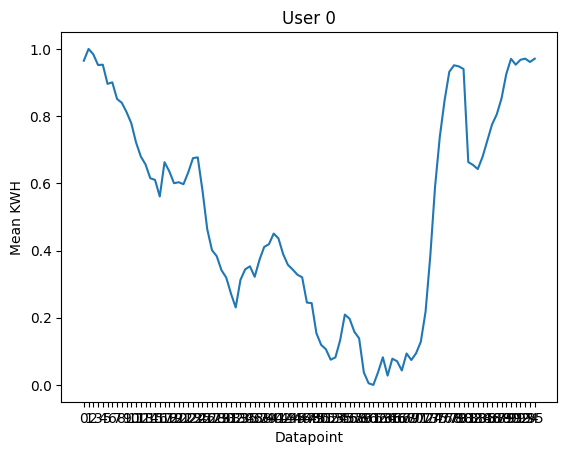

In [10]:
# After Normalized
# Select row for user 0
user0_data = df_test.loc[0]

plt.plot(user0_data.index, user0_data.values)
plt.xlabel('Datapoint')
plt.ylabel('Mean KWH')
plt.title('User 0')
plt.show()

In [11]:
for index, row in df_test.iterrows():
    print(f'MeterID {index}: min = {row.min()}, max = {row.max()}')

MeterID 0: min = 0.0, max = 1.0
MeterID 1: min = 0.0, max = 0.9999999999999999
MeterID 2: min = 0.0, max = 1.0
MeterID 3: min = 0.0, max = 1.0
MeterID 4: min = 0.0, max = 1.0
MeterID 5: min = 0.0, max = 0.0
MeterID 6: min = 0.0, max = 1.0000000000000002
MeterID 7: min = 0.0, max = 0.9999999999999999
MeterID 8: min = 0.0, max = 1.0000000000000002
MeterID 9: min = 0.0, max = 1.0
MeterID 10: min = 0.0, max = 1.0
MeterID 11: min = 0.0, max = 1.0
MeterID 12: min = 0.0, max = 1.0
MeterID 13: min = 0.0, max = 1.0
MeterID 14: min = 0.0, max = 1.0
MeterID 15: min = 0.0, max = 1.0
MeterID 16: min = 0.0, max = 1.0
MeterID 17: min = 0.0, max = 1.0
MeterID 18: min = 0.0, max = 1.0
MeterID 19: min = 0.0, max = 0.9999999999999999
MeterID 20: min = 0.0, max = 1.0
MeterID 21: min = 0.0, max = 1.0
MeterID 22: min = 0.0, max = 0.9999999999999998
MeterID 23: min = 0.0, max = 1.0
MeterID 24: min = 0.0, max = 1.0
MeterID 25: min = 0.0, max = 0.9999999999999999
MeterID 26: min = 0.0, max = 1.0
MeterID 27: mi

In [19]:
import math
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
cluster_count = math.ceil(math.sqrt(len(df_test))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
print(cluster_count)

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=-1, random_state=42)

labels = km.fit_predict(df_test)  #Index of the cluster each sample belongs to.

45


In [18]:
labels

2001

In [20]:
centroids = km.cluster_centers_
centroids  # three rows and two columns

array([[[0.60480034],
        [0.74153328],
        [0.69663686],
        ...,
        [0.74470801],
        [0.67601033],
        [0.60806574]],

       [[0.2290446 ],
        [0.26503623],
        [0.21139138],
        ...,
        [0.32487421],
        [0.28967144],
        [0.21237681]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.58441524],
        [0.63361199],
        [0.57173177],
        ...,
        [0.71186165],
        [0.6704109 ],
        [0.59789485]],

       [[0.26498878],
        [0.3406979 ],
        [0.29032747],
        ...,
        [0.33477923],
        [0.2944528 ],
        [0.22129734]],

       [[0.2723277 ],
        [0.36369773],
        [0.29075954],
        ...,
        [0.40919455],
        [0.37577933],
        [0.27467926]]])

In [21]:
inertia = km.inertia_
print("Inertia (45 clusters):", inertia)

Inertia (45 clusters): 0.242413257592592


The "best" inertia is 0, and our score is pretty far from that. Does that mean our model is "bad?" Not necessarily. Inertia is a measurement of distance (like mean absolute error). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes.

However, it would be helpful to have metric that was easier to interpret, and that's where **silhouette score** comes in. Silhouette score measures the distance between different clusters. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia.

In [23]:
from sklearn.metrics import silhouette_score

ss = silhouette_score(df_test, km.labels_)
print("Silhouette Score (45 clusters):", ss)

Silhouette Score (45 clusters): -0.027434635691869002


It's important to remember that these performance metrics are the result of the number of clusters we told our model to create. In unsupervised learning, the number of clusters is hyperparameter that you set before training your model. So what would happen if we change the number of clusters? Will it lead to better performance? Let's try!

### Saving the model

In [13]:
# import pickle

# with open("model/timeserieskmeans_model.pkl", "wb") as f:
#     pickle.dump(km, f)

### Loading the model

In [14]:
# with open("model/timeserieskmeans_model.pkl", "rb") as f:
#     model = pickle.load(f)

In [15]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_test))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

In [16]:
print(som_x, som_y)

7 7


45


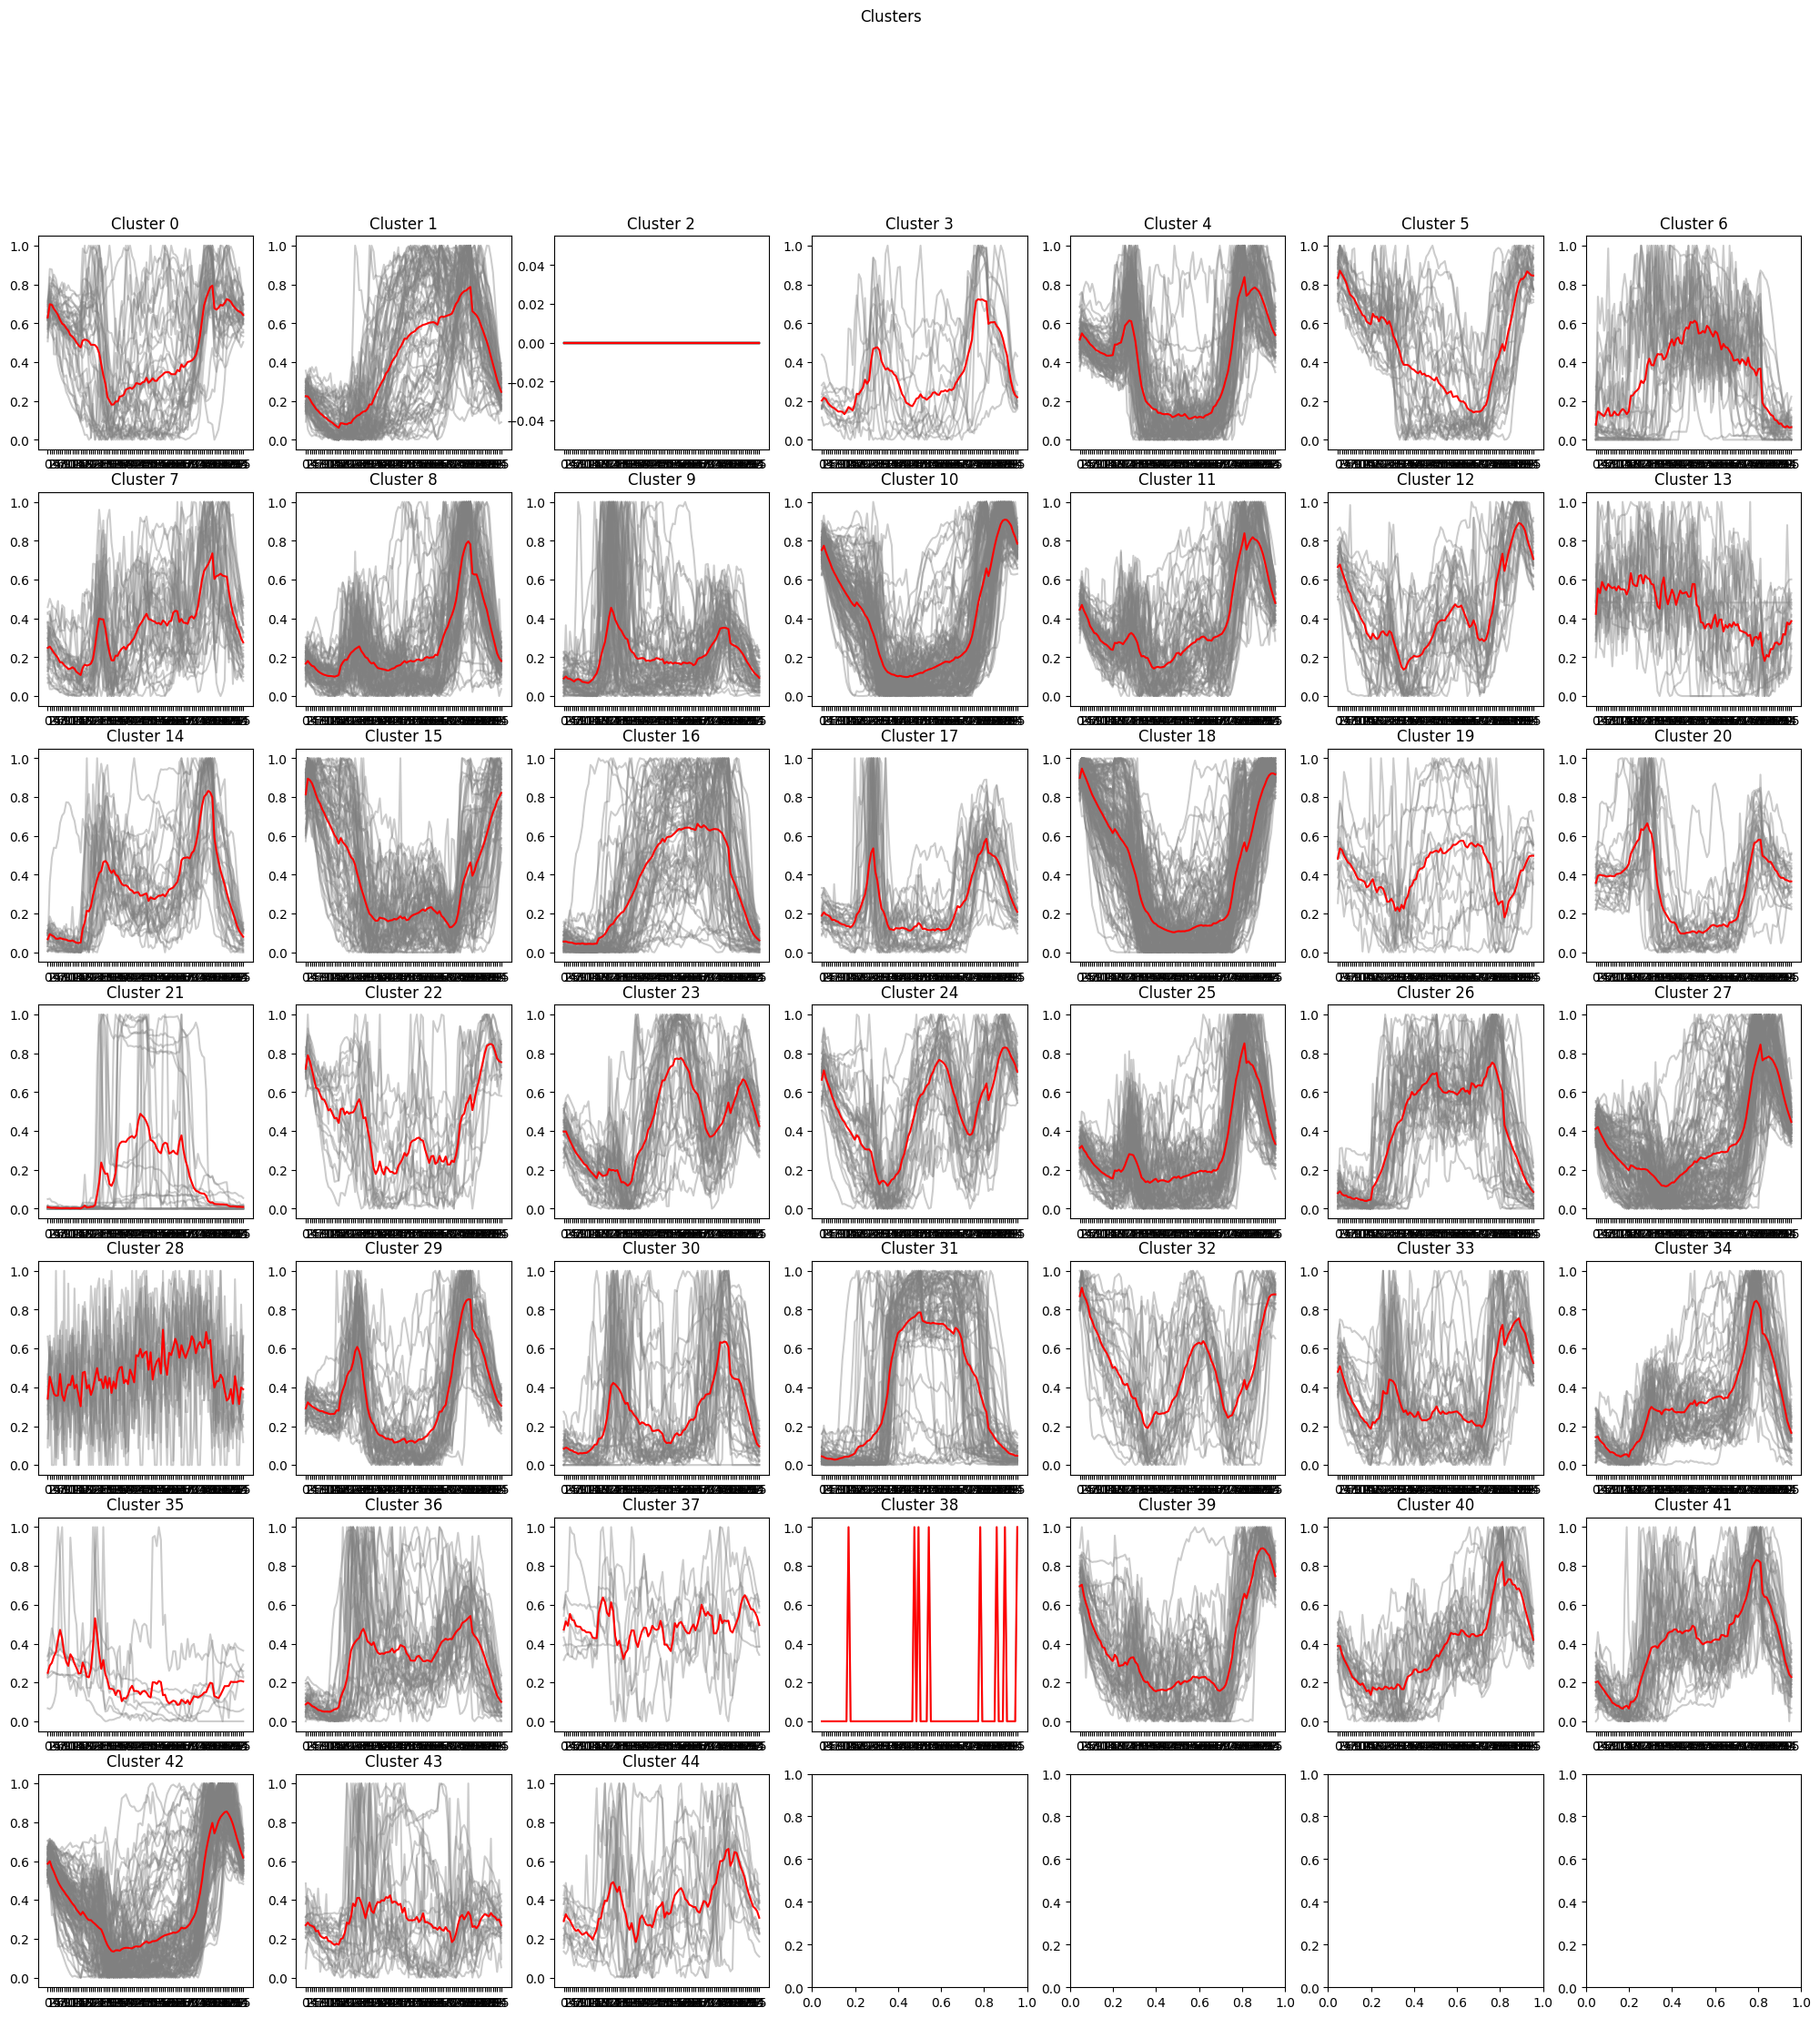

In [24]:
plot_count = math.ceil(math.sqrt(cluster_count))
print(cluster_count)
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df_test.iloc[i],c="gray",alpha=0.4)
                cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

45


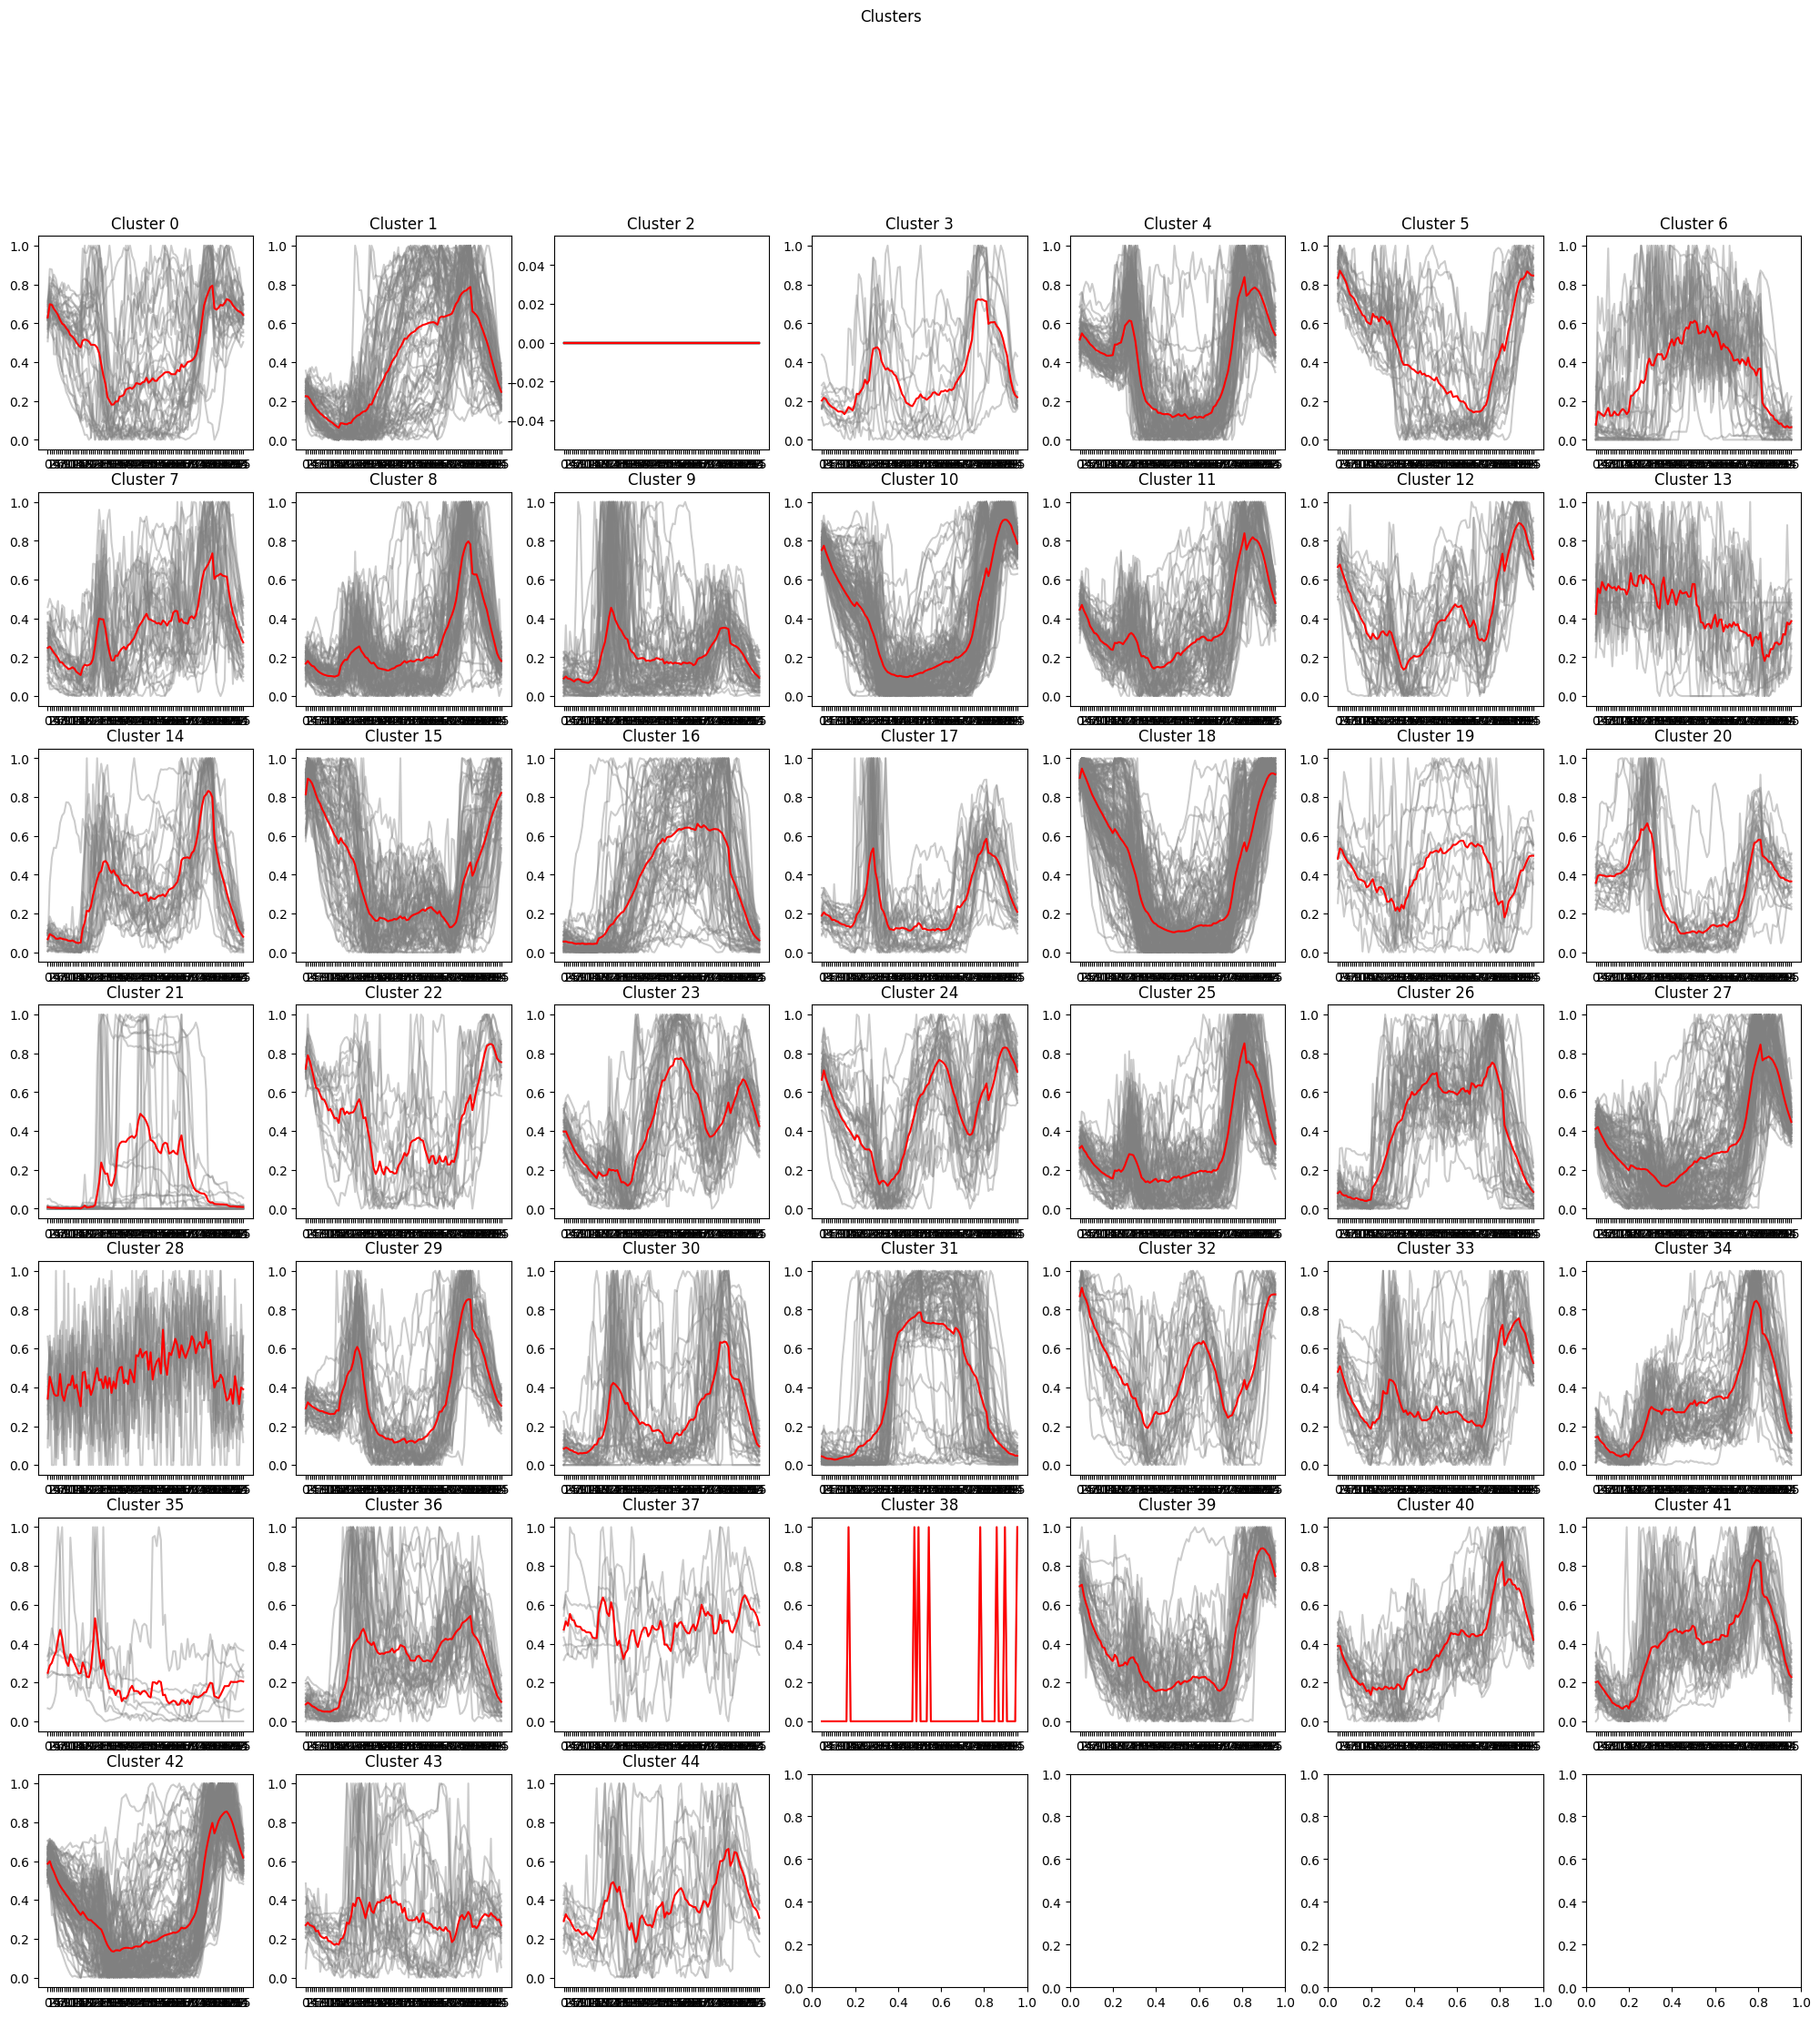

In [25]:
plot_count = math.ceil(math.sqrt(cluster_count))
print(cluster_count)
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df_test.iloc[i],c="gray",alpha=0.4)
                cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

45


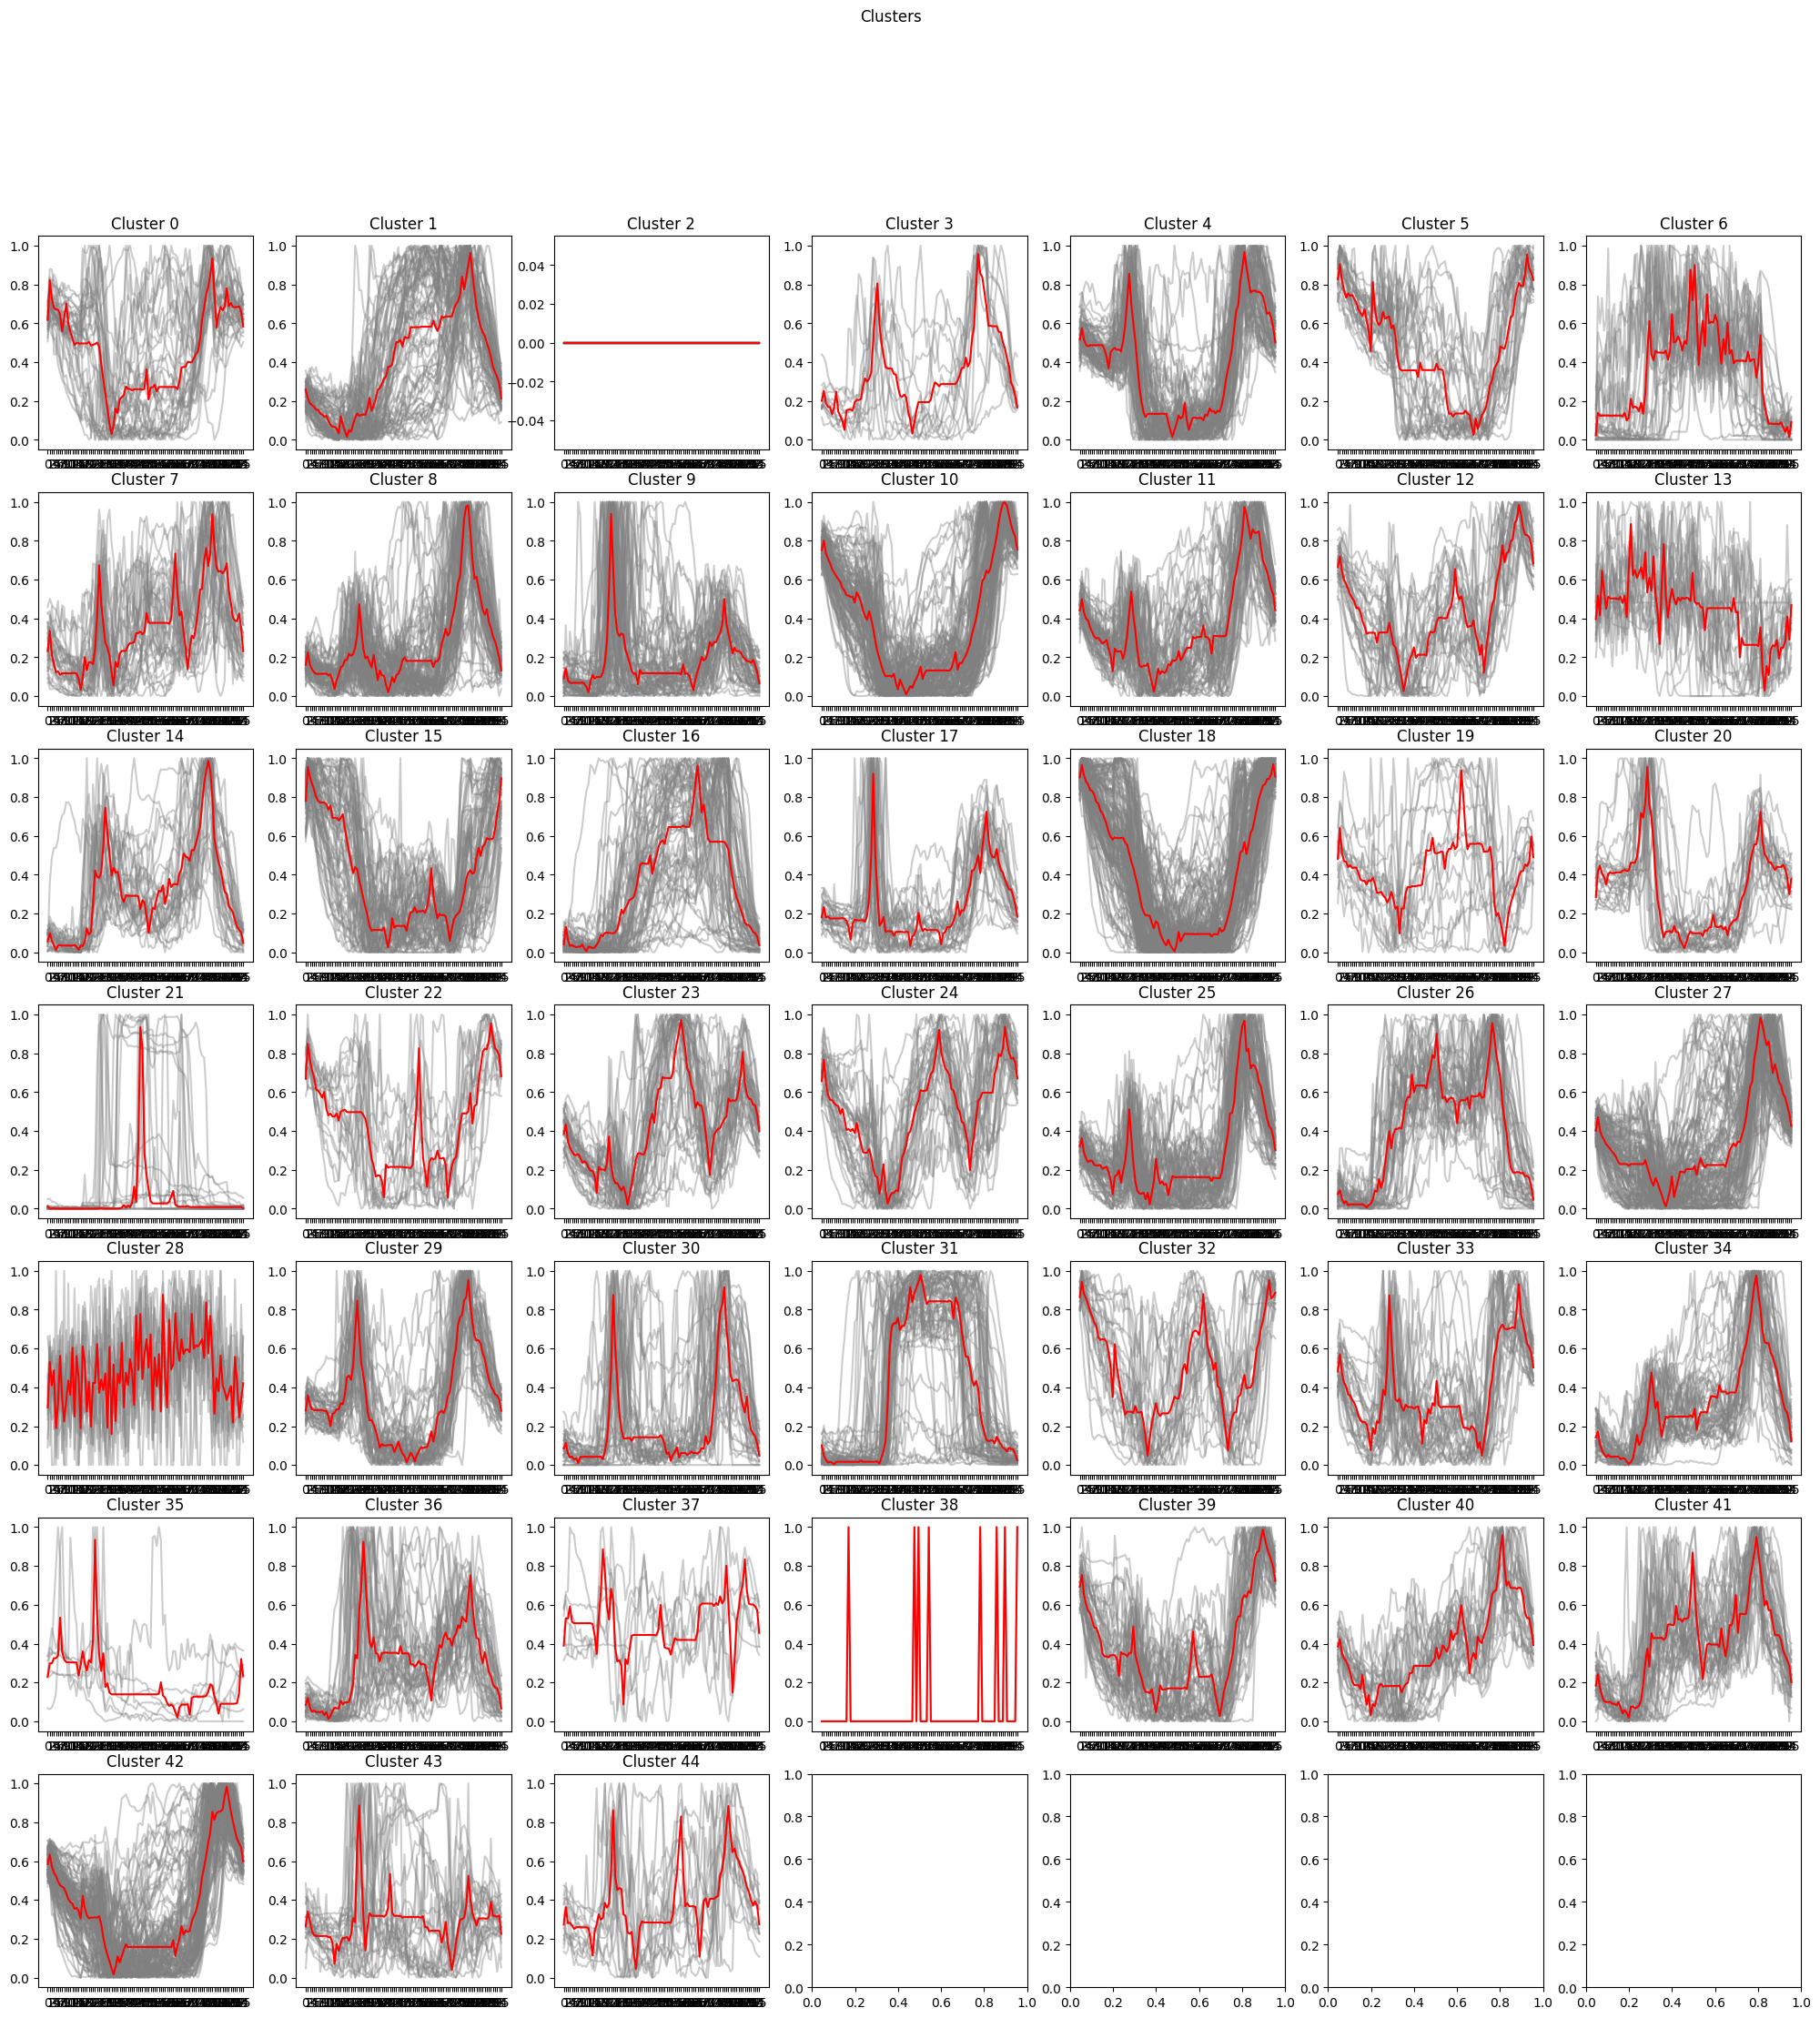

In [26]:
plot_count = math.ceil(math.sqrt(cluster_count))
print(cluster_count)
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df_test.iloc[i],c="gray",alpha=0.4)
                cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

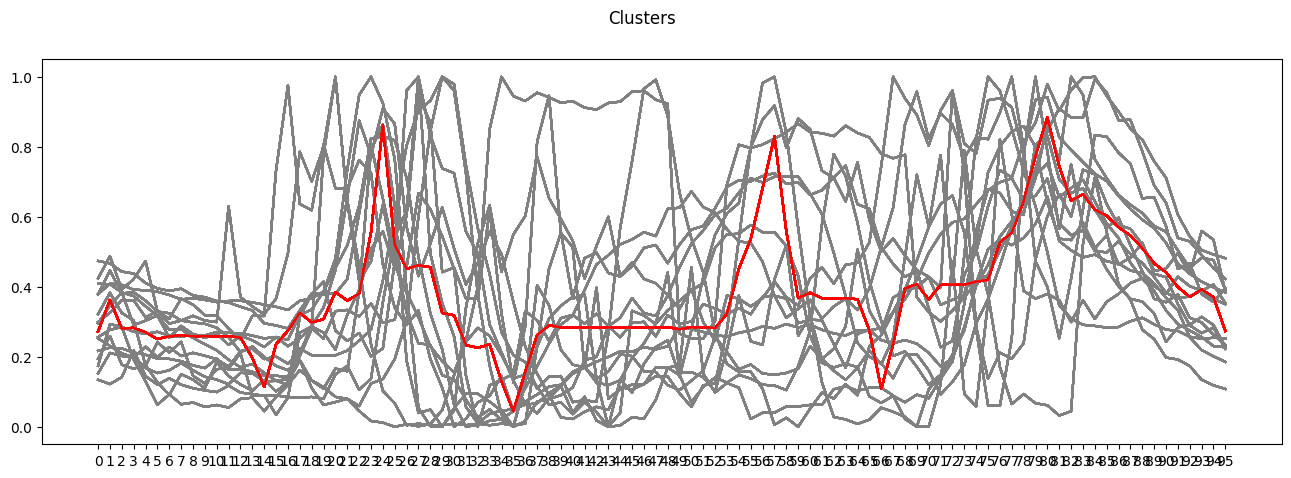

In [91]:
# Check Cluster
Cluster = 44
fig, axs = plt.subplots(1,1,figsize=(16,5))
fig.suptitle('Clusters')
# row_i=0
# column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==Cluster):
                axs.plot(df_test.iloc[i],c="gray",alpha=0.4)
                cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs.plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")

plt.show()

## Cluster Distribution

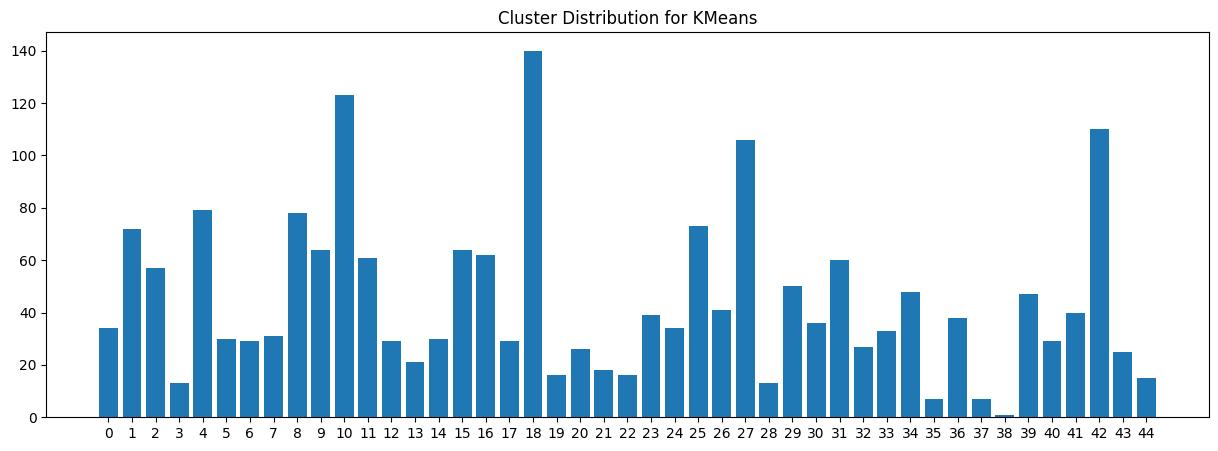

In [27]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
# cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

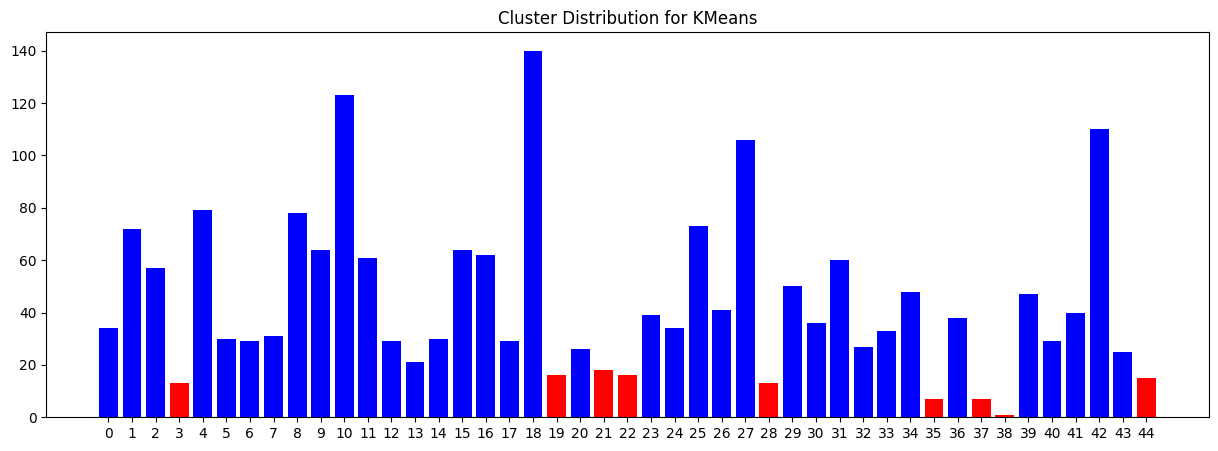

In [28]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(cluster_count)]
colors = ['red' if c < 20 else 'blue' for c in cluster_c]  # specify colors based on cluster size
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n, cluster_c, color=colors)
plt.show()

## Cluster Mapping

In [92]:
labels

array([18,  8, 34, ..., 32,  8, 33])

In [93]:
namesofMySeries = df_test.reset_index()['user'].to_list()

In [94]:
print(len(namesofMySeries))
namesofMySeries[:5]

2001


[0, 1, 2, 3, 4]

In [95]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]

In [96]:
print(len(fancy_names_for_labels))
fancy_names_for_labels[:5]

2001


['Cluster 18', 'Cluster 8', 'Cluster 34', 'Cluster 41', 'Cluster 31']

In [97]:
# fancy_names_for_labels = [f"Cluster {label}" for label in labels]
groups_of_cluster = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [104]:
groups_of_cluster[groups_of_cluster['Cluster']== 'Cluster 38']

Cluster
Series            
510     Cluster 38

In [114]:
# Selected the noise users
noise_users = groups_of_cluster[groups_of_cluster['Cluster'].isin(['Cluster 2', 
                                                                   'Cluster 3',
                                                                   'Cluster 19',
                                                                   'Cluster 21', 
                                                                   'Cluster 22', 
                                                                   'Cluster 28', 
                                                                   'Cluster 35', 
                                                                   'Cluster 37', 
                                                                   'Cluster 38', 
                                                                   'Cluster 44'])]
len(noise_users)

163

In [115]:
noise_users = noise_users.reset_index()

In [117]:
noise_users.to_csv('datasets/noise_users.csv', index=False)
print('Saved successfully')

Saved successfully


## Curse of Dimensionality

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(df_test)

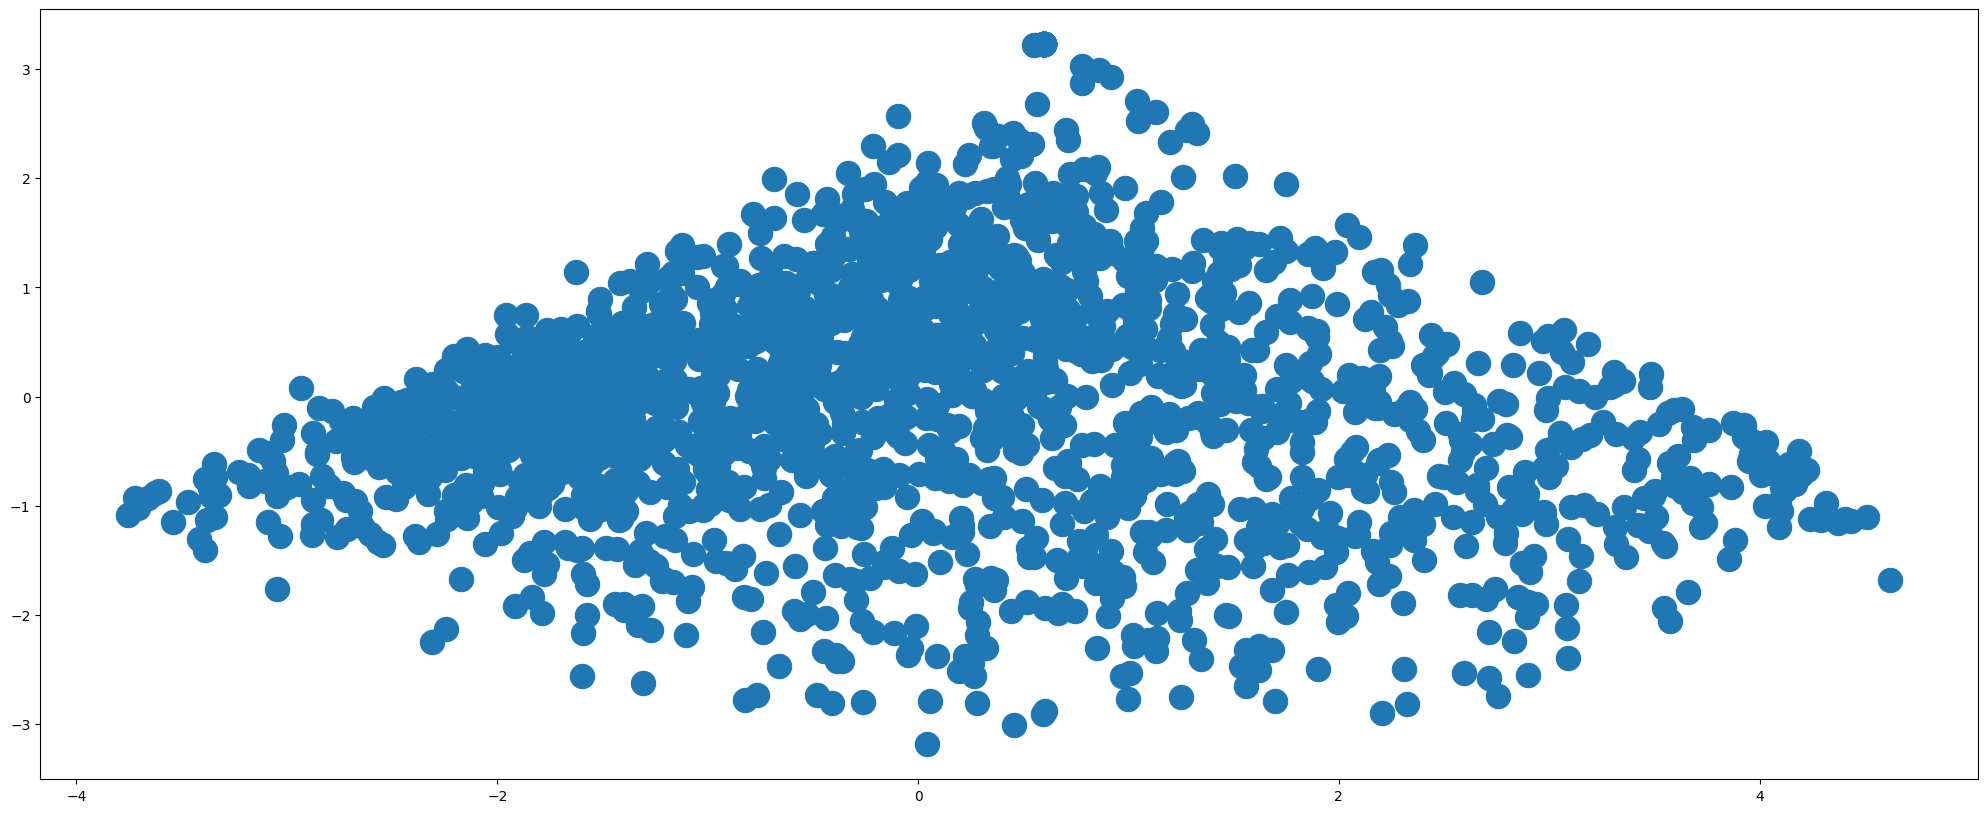

In [30]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

In [36]:
print(mySeries_transformed[0:5])    # mySeries_transformed has shape (2001, 2)

[[-2.28631533 -1.25898085]
 [ 0.32848045  1.88694899]
 [ 1.51133709  0.14950878]
 [ 0.66031881  0.95187772]
 [ 3.92594036 -0.26100772]]


In [37]:
kmeans = KMeans(n_clusters=cluster_count, max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

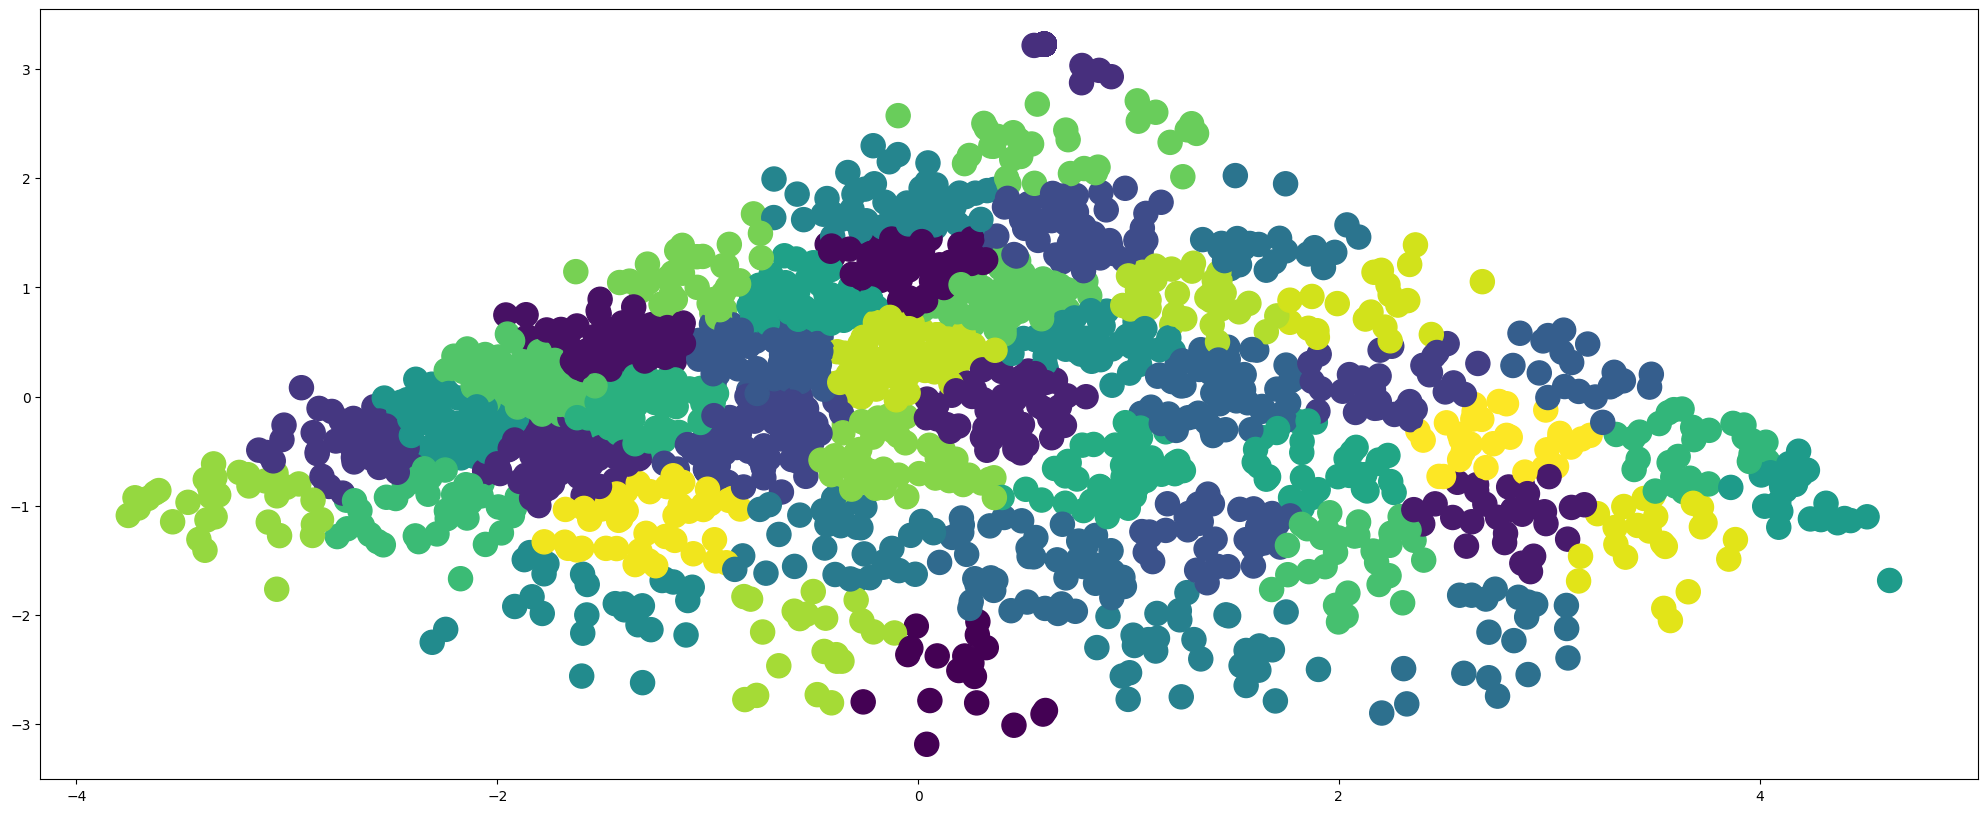

In [38]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()